# Malaria Detection TF Convolutional Neural Net

Notebook creates a classifier which examines blood cells and returns whether the image represents cells that have been parasitized by malaria or not. Notebook uses a TensorFlow model for feature extaction and modeling.

## Initializations and Seed

In [215]:
%matplotlib inline
import tensorflow as tf
from tensorflow.data import AUTOTUNE
import tensorflow_datasets as tfds
import pandas as pd ### reading and processing data
import numpy as np### math computations
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Normalization, Dense, InputLayer, Conv2D, MaxPool2D, Flatten, BatchNormalization
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy
from tensorflow.keras.optimizers import Adam
import random
from sklearn.metrics import classification_report

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
# Set the random seeds for reproducibility
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

## Preprocessing

In [5]:
ds, dataset_info = tfds.load('malaria', split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'], shuffle_files=True, with_info=True)

In [6]:
dataset_info

tfds.core.DatasetInfo(
    name='malaria',
    full_name='malaria/1.0.0',
    description="""
    The Malaria dataset contains a total of 27,558 cell images with equal instances
    of parasitized and uninfected cells from the thin blood smear slide images of
    segmented cells.
    """,
    homepage='https://lhncbc.nlm.nih.gov/publication/pub9932',
    data_dir='/Users/ericmacdougall/tensorflow_datasets/malaria/1.0.0',
    file_format=tfrecord,
    download_size=337.08 MiB,
    dataset_size=317.62 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    nondeterministic_order=False,
    splits={
        'train': <SplitInfo num_examples=27558, num_shards=4>,
    },
    citation="""@article{rajaraman2018pre,
      title={Pre-trained convolutional neural networks as feature extractors toward
      improved

In [7]:
train = ds[0]
len(train)

22046

In [8]:
train.take(1)

<_TakeDataset element_spec={'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}>

In [9]:
val = ds[1]
len(val)

2756

In [10]:
test = ds[2]
len(test)

2756

In [11]:
ds

[<_PrefetchDataset element_spec={'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}>,
 <_PrefetchDataset element_spec={'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}>,
 <_PrefetchDataset element_spec={'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}>]

In [12]:
print(train)

<_PrefetchDataset element_spec={'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}>


In [13]:
for i in val.take(1):
    print(i)

{'image': <tf.Tensor: shape=(232, 229, 3), dtype=uint8, numpy=
array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)>, 'label': <tf.Tensor: shape=(), dtype=int64, numpy=0>}


2025-05-12 01:21:39.118053: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:387] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608
2025-05-12 01:21:39.143216: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2025-05-12 01:21:39.625044: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


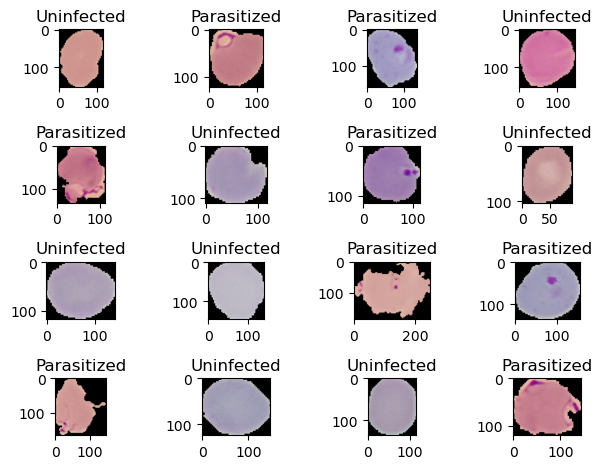

In [14]:
my_dict = {0: 'Parasitized', 1: 'Uninfected'}
for i, sample in enumerate(train.take(16)):
    axe = plt.subplot(4, 4, 1+i)
    plt.imshow(sample['image'])
    plt.title(my_dict[sample['label'].numpy()])
plt.tight_layout()
plt.show()

In [15]:
IM_SIZE = 224
BATCH_SIZE=32

In [16]:
def resize_image(inputs):
    image = tf.image.resize(tf.cast(inputs['image'], tf.float32), (IM_SIZE, IM_SIZE)) / 255.0
    label = tf.cast(inputs['label'], tf.float32)  # Cast labels to float32
    return image, label

In [17]:
train = train.map(resize_image).shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [18]:
for images, labels in train.take(1):
    print("Image batch shape:", images.shape)
    print("Label batch shape:", labels.shape)

Image batch shape: (32, 224, 224, 3)
Label batch shape: (32,)


In [19]:
for images, labels in train.take(1):
    print("Label batch shape:", labels)

Label batch shape: tf.Tensor(
[1. 0. 1. 0. 0. 1. 0. 1. 1. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 0. 1. 1. 0. 1.
 1. 0. 0. 0. 0. 1. 1. 1.], shape=(32,), dtype=float32)


2025-05-12 01:21:41.287700: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [20]:
val = val.map(resize_image).shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [21]:
print("Train batches:")
for batch in train.take(1):
    print(batch[0].shape, batch[1].shape)

print("Val batches:")
for batch in val.take(1):
    print(batch[0].shape, batch[1].shape)

Train batches:
(32, 224, 224, 3) (32,)
Val batches:
(32, 224, 224, 3) (32,)


In [22]:
test = test.map(resize_image).shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [23]:
len(train)

689

EDA is unecessary given that there are no numeric fields and no data beyond the images and the labels.

## Modeling

In [25]:
model = tf.keras.Sequential([
    InputLayer(input_shape = (IM_SIZE, IM_SIZE, 3)),
    Conv2D(filters=6, kernel_size=3, strides=1, padding='valid', activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides=2),
    Conv2D(filters=16, kernel_size=3, strides=1, padding='valid', activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides=2),
    Flatten(),
    Dense(100, activation='relu'),
    BatchNormalization(),
    Dense(10, activation='relu'),
    BatchNormalization(),
    Dense(1, activation='sigmoid')
]
                           )
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 6)    │           168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 6)    │            24 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 6)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 16)   │           880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 109, 109, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 46656)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │     4,665,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,010 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 10)             │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,668,297 (17.81 MB)

 Trainable params: 4,668,033 (17.81 MB)

 Non-trainable params: 264 (1.03 KB)

In [26]:
loss_fn = BinaryCrossentropy()

In [27]:
model.compile(
    optimizer=Adam(learning_rate=.01),
    loss=loss_fn, 
    metrics=[BinaryAccuracy()]
)

In [28]:
for images, labels in train.take(1):
    print("Image batch shape:", images.shape)
    print("Label batch shape:", labels.shape)
    preds = model(images)
    print("Output shape:", preds.shape)


Image batch shape: (32, 224, 224, 3)
Label batch shape: (32,)
Output shape: (32, 1)


In [29]:
for i in train.take(1):
    print(i)

(<tf.Tensor: shape=(32, 224, 224, 3), dtype=float32, numpy=
array([[[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        ...,

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]],




2025-05-12 01:21:42.946490: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [30]:
history = model.fit(x=train, validation_data=val, epochs=20, verbose=1, batch_size=BATCH_SIZE)
history

Epoch 1/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 236s 338ms/step - binary_accuracy: 0.6585 - loss: 0.6321 - val_binary_accuracy: 0.6230 - val_loss: 0.6926
Epoch 2/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 235s 341ms/step - binary_accuracy: 0.8221 - loss: 0.3986 - val_binary_accuracy: 0.8505 - val_loss: 0.6718
Epoch 3/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 228s 331ms/step - binary_accuracy: 0.9239 - loss: 0.2190 - val_binary_accuracy: 0.5806 - val_loss: 0.5508
Epoch 4/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 247s 358ms/step - binary_accuracy: 0.9239 - loss: 0.2080 - val_binary_accuracy: 0.9187 - val_loss: 0.2882
Epoch 5/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 230s 334ms/step - binary_accuracy: 0.9358 - loss: 0.1786 - val_binary_accuracy: 0.5497 - val_loss: 1.1074
Epoch 6/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 227s 330ms/step - binary_accuracy: 0.9377 - loss: 0.1784 - val_binary_accuracy: 0.8799 - val_loss: 0.4400
Epoch 7/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 233s 338ms/step - binary_accuracy: 0.9461 - loss: 0.1616 - val_binary_accuracy: 0.93

## Plotting and Model Evaluation

In [227]:
history.history.keys()

dict_keys(['binary_accuracy', 'loss', 'val_binary_accuracy', 'val_loss'])

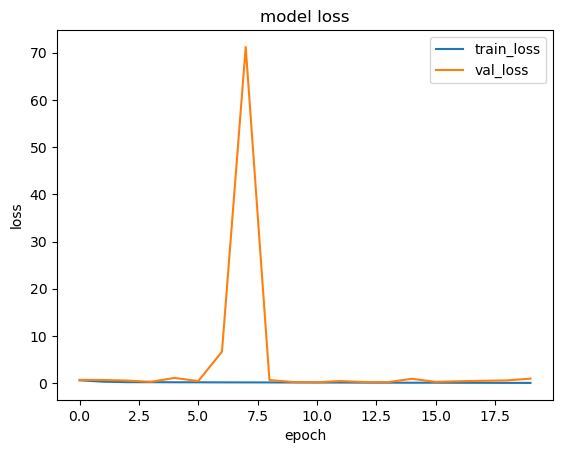

In [76]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
#plt.axhline(y=min(history.history['loss']), color='g', linestyle='--', label='Horizontal Line at Min')

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

Plot shows anomalous spike in validation loss at epoch 6.

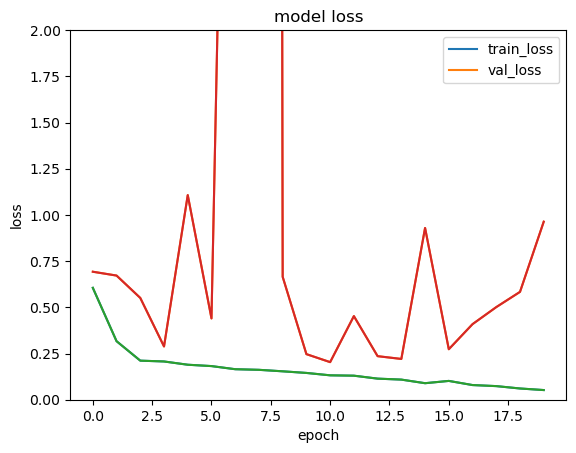

In [81]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
#plt.axhline(y=min(history.history['loss']), color='g', linestyle='--', label='Horizontal Line at Min')

plt.title('model loss')
plt.ylabel('loss')
plt.ylim([0,2])
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

This plot shows the training and validation loss over a smaller range. This plot does not show all the data but provides a moer illuminating picture than the previous anomaly-skewed plot.

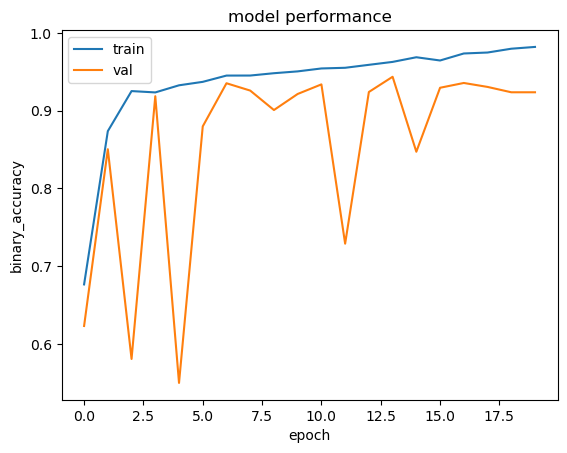

In [69]:
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('model performance')
plt.ylabel('binary_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'])
plt.show()

In [90]:
model.evaluate(test)

87/87 ━━━━━━━━━━━━━━━━━━━━ 10s 106ms/step - binary_accuracy: 0.9297 - loss: 0.7220


[0.6616082191467285, 0.9310594797134399]

In [195]:
def parasitic(x):
    if x<0.5:
        return 'Parasitized'
    else:
        return 'Uninfected'

In [197]:
parasitic(model.predict(test.take(1))[0][0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


'Parasitized'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


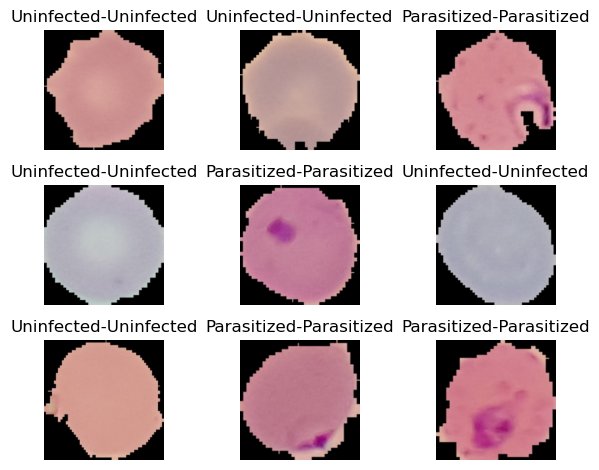

In [199]:
for image, label in test.take(1):
    for i in range(9):
        axe = plt.subplot(3, 3, i + 1)
        plt.imshow(image[i])
        plt.title(parasitic(label.numpy()[i])+"-"+parasitic(model.predict(image)[i]))
        plt.axis('off')
plt.tight_layout()
plt.show()

In [191]:
classes = np.array(['Parasitized', 'Uninfected'])


Classification Report:
              precision    recall  f1-score   support

         0.0     0.9735    0.8855    0.9274      1371
         1.0     0.8960    0.9762    0.9343      1385

    accuracy                         0.9311      2756
   macro avg     0.9347    0.9308    0.9309      2756
weighted avg     0.9345    0.9311    0.9309      2756



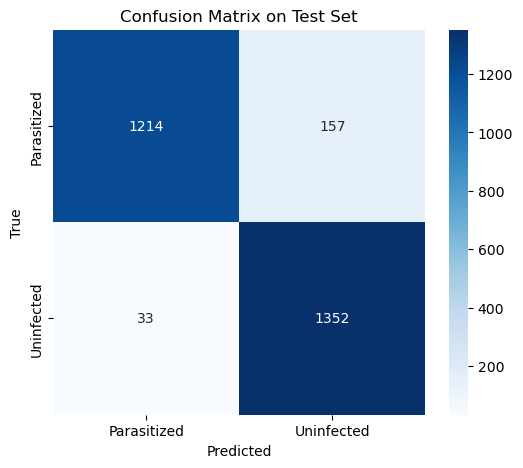

In [193]:
all_preds = []
all_labels = []

for images, labels in test:
    probs = model.predict(images, verbose=0)
    preds = (probs >= 0.5).astype(int)
    all_preds.extend(preds.flatten())
    all_labels.extend(labels.numpy().flatten())

# Convert to NumPy arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Classification report
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, digits=4))

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix on Test Set")
plt.show()


In [233]:
len(train), len(val), len(test)

(689, 87, 87)

Classification report shows a high accuracy for both classes. This model, however, shows that it is more likely to classify parasitized cells as uninfected than to classify uninfected cells as parastized. Given that this relates to a serious health matter, one would really want those situations reversed. A person diagnosed with parasitized cells related to malaria would be expected to receive the medical followup that would lead to a discovery of the error. A person diagnosed as uninfected who was infected, wouldn't necessarily have need for more followup.

## Model Saving and Loading

In [143]:
model.save('lenet.keras')

In [153]:
model.save_weights("lenet_weights.weights.h5")

In [163]:
model.weights

[<Variable path=sequential/conv2d/kernel, shape=(3, 3, 3, 6), dtype=float32, value=[[[[ 0.08482233 -0.16105638 -0.2292711   0.6413045  -0.22072239
      0.05550488]
    [ 1.8519915  -0.37444538 -0.13544123 -0.9315137  -0.2662122
     -0.04651035]
    [-0.23041989 -0.23257945 -0.13105239  0.5828878  -0.23129983
     -0.18441167]]
 
   [[-0.1415656  -0.27370706 -0.23826773  0.78812295  0.18254349
     -0.20793869]
    [ 1.8916168  -0.24379684 -0.01661704 -0.9308419  -0.14335912
     -0.2543007 ]
    [-0.6940706   0.2205085  -0.20380284  0.59241045 -0.1138081
     -0.29057822]]
 
   [[-0.12323745 -0.2325889  -0.02786975  0.23673582 -0.2710248
     -0.0192979 ]
    [ 0.9308097  -0.12119953  0.10045671 -1.0692786  -0.12734422
     -0.19311179]
    [-0.9168212   0.05787922 -0.08788607  0.26198027 -0.31180656
     -0.26454598]]]
 
 
  [[[ 0.05576941  0.05849883 -0.14734133  0.8553671  -0.31536654
     -0.29899606]
    [ 2.0792856   0.06220988 -0.13513744 -0.77924484 -0.16122419
      0.109443

## Conclusions

- This model largely demonstrates TensorFlow's reliability in creating a model for predicting malaria symptoms in blood samples. This dataset is publicly accessable through TensorFlow's documentation.
- The model shows an overall accuracy of 93% on the test set. A CSV Log or a if-then statement could save the epoch with the best metrics for the model and then it can be loaded for evaluation on the test set.
- Model can be improved through more epochs and different/additional layers. This carries with it, of course, likely more computational time, complexity, and resources with a possible danger in overfitting.
- Model uses a LeNet architecture in feature extraction. Extracting more features through additional layers or neurons may yield better performance metrics.